In [108]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [109]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [110]:
# Metodo de puntos interiores
def qp_intpoint(Q, c, F, d, iter = 100, tol = 1e-5, decreasing_factor = 0.5, starting_point = -1):
    m, n = F.shape
    # v represents vector of all variables [x, z, mu]
    # the initial guess must have z, mu > 0
    if type(starting_point) == np.ndarray and starting_point.shape == (n, 1):
      print('starter given')
      v = np.block([[starting_point],[np.ones((2*m, 1))]])
    else:
      v = np.ones((n + 2*m, 1))

    def FNewton(v_k):
        # x is the first n entries
        # z is the next m entries
        # mu is the next m entries
        x, z, mu = np.split(v_k, [n, n+m, n+m+m])[:-1]
        complementary_measure = ((z.T@mu)/m)[0][0]
        disturbance = decreasing_factor*complementary_measure
        return np.block([[Q@x + c - F.T@mu],
                         [np.multiply(z, mu) - disturbance],
                         [-F@x + z + d]])

    # The Jacobian of the matrix given by the FNewton() function
    def Jacobian_FNewton(v_k):
        Z = np.diag(v_k[n:n+m, :].flatten())
        MU = np.diag(v_k[n+m:n+m+m, :].flatten())
        return np.block(
                   [[Q               , np.zeros((n, m)) , -F.T],
                    [np.zeros((m, n)), MU               , Z],
                    [-F              , np.eye(m)        , np.zeros((m, m)) ]])

    def get_delta_v(v_k, F_vk):
        J = Jacobian_FNewton(v_k)
        adjustedF = F_vk
        adjustedJ = J
        z = v_k[n: n+m, :].flatten()
        ZInv = np.diag(1/z)
        adjustedF[n:n+m, :] = ZInv @ adjustedF[n:n+m, :]
        adjustedJ[n:n+m, :] = ZInv @ adjustedJ[n:n+m, :]
        return np.linalg.solve(adjustedJ, -adjustedF)

    def get_alpha(v_k, delta_v_k):
        alpha = 1
        for i in range(n, n+m+m):
            if delta_v_k[i, 0] < 0:
                alpha = min(alpha, -v_k[i, 0]/delta_v_k[i, 0])
        return alpha*0.95

    it = 0
    current_F = FNewton(v)
    while (np.linalg.norm(current_F.flatten())**2 > tol) and it < iter:
        delta_v = get_delta_v(v, current_F)
        alpha = get_alpha(v, delta_v)
        v += alpha*delta_v
        current_F = FNewton(v)
        it += 1
        decreasing_factor *= 1/2
        if(it%20==0):
          print(it, np.linalg.norm(current_F.flatten()))
    return v[0:n, :], v[n+m:n+2*m, :], it

In [111]:
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# # data (as pandas dataframes)
x = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

print(breast_cancer_wisconsin_diagnostic.variables)


                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

In [112]:
x

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


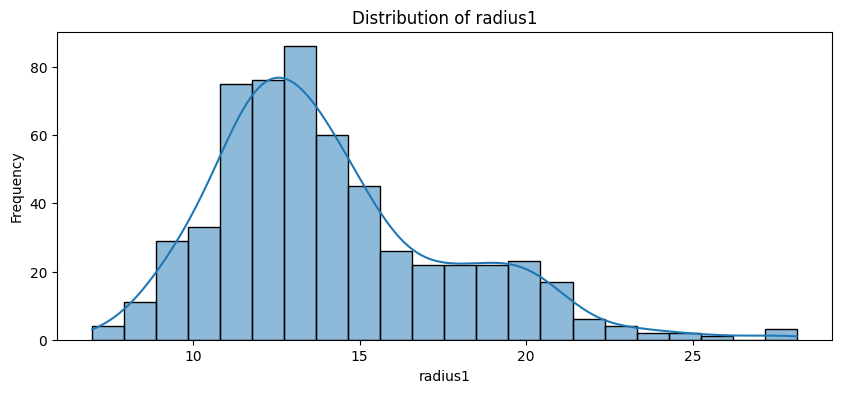

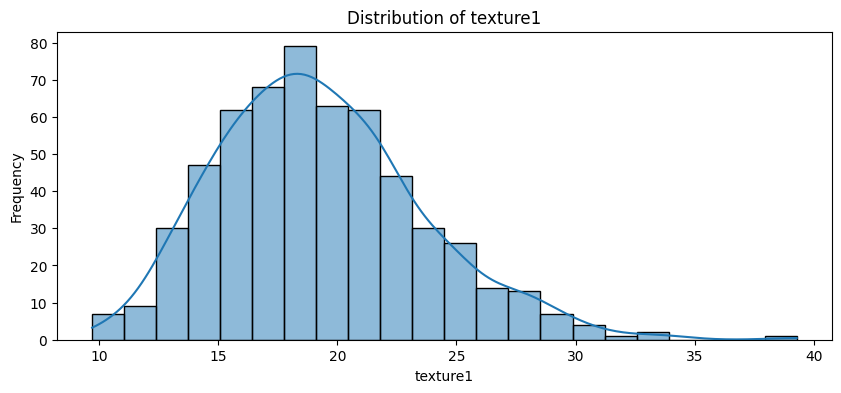

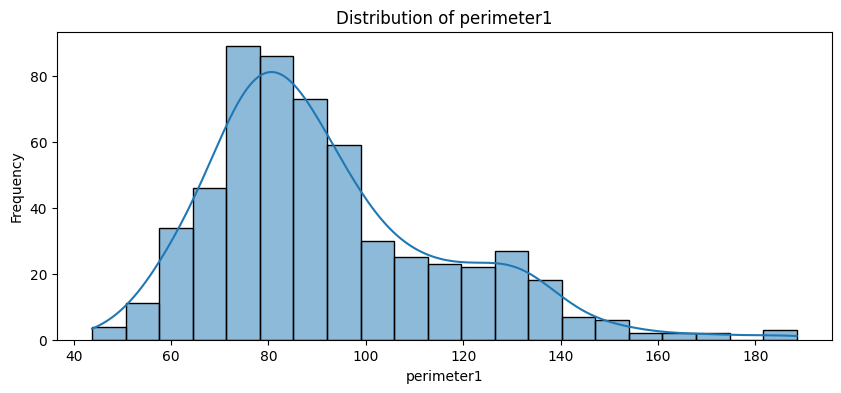

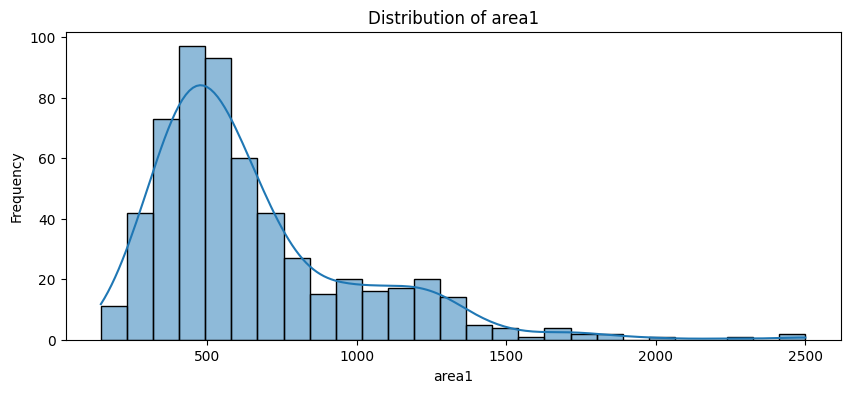

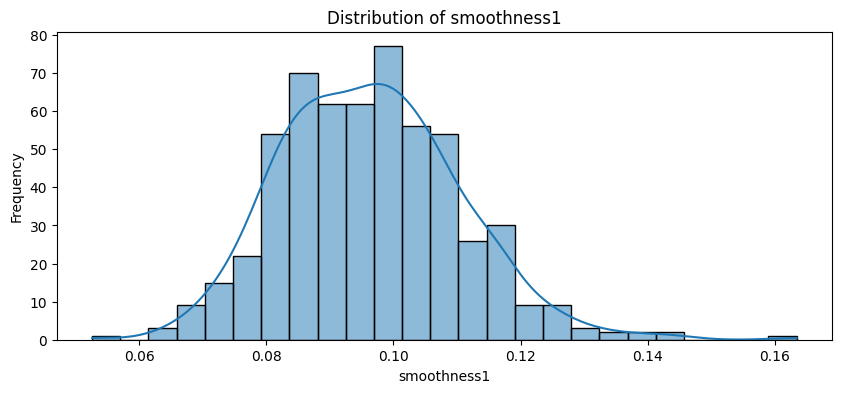

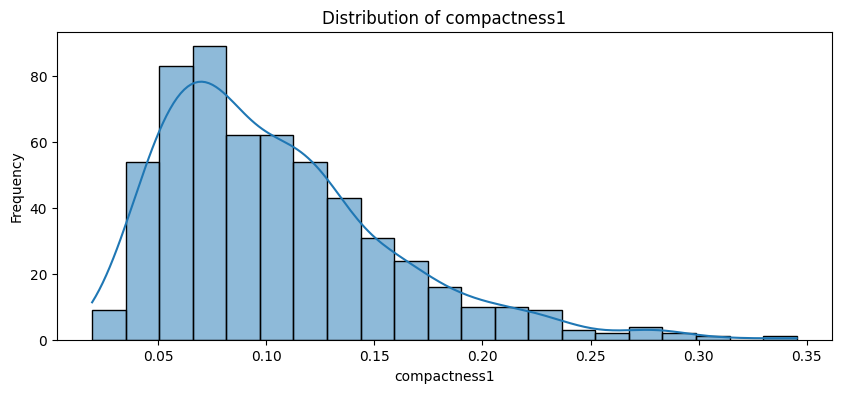

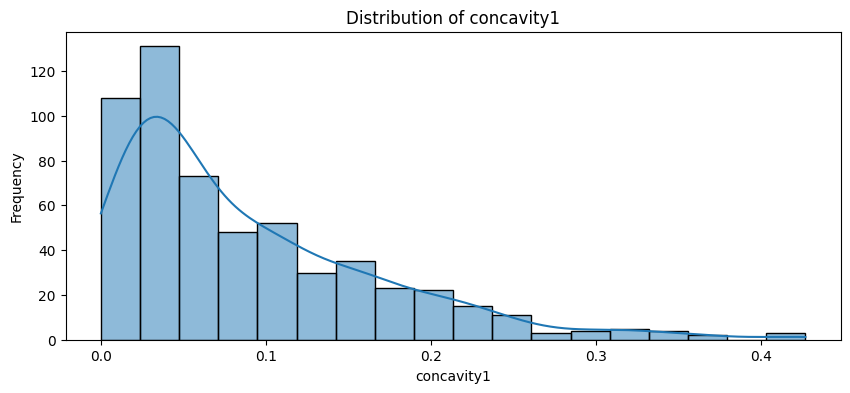

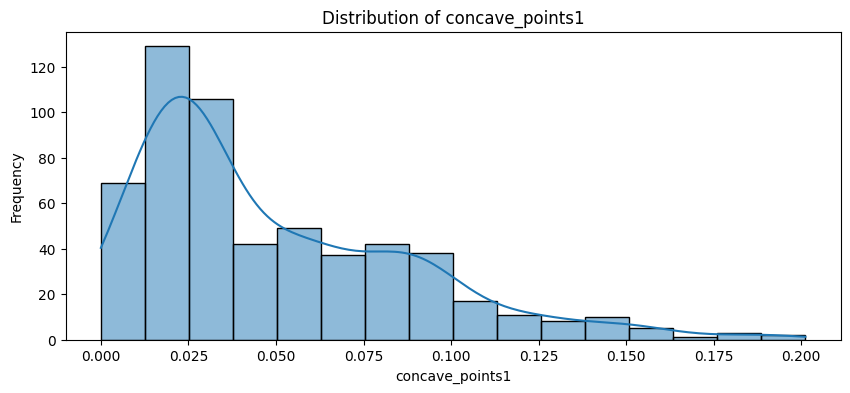

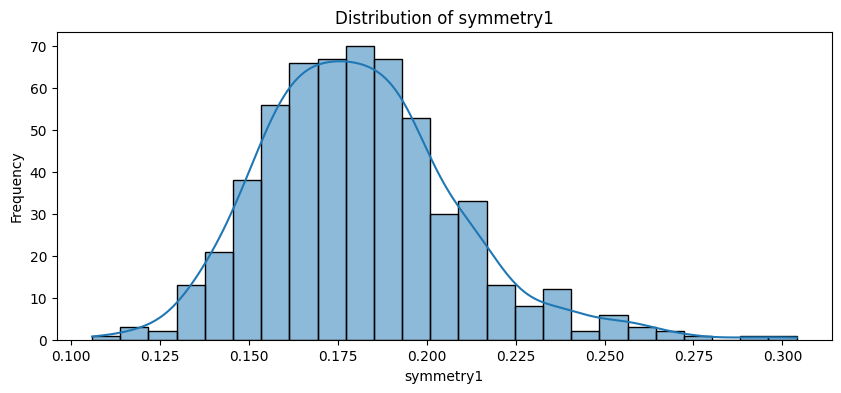

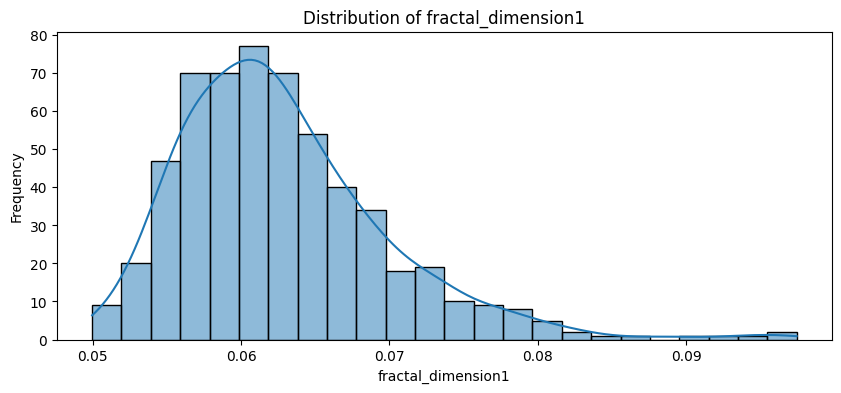

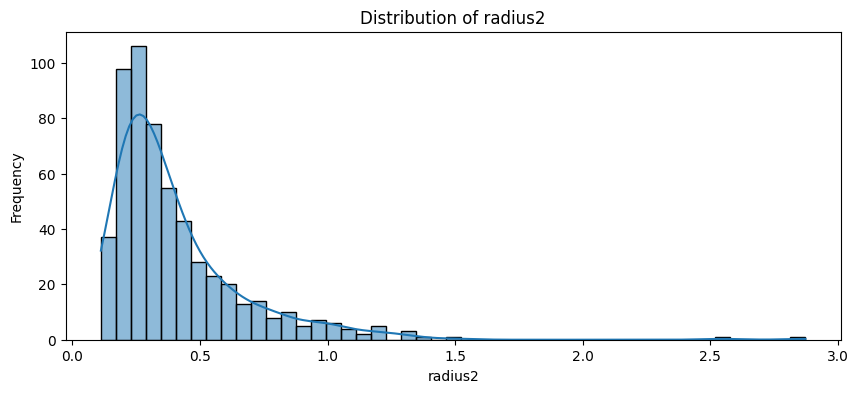

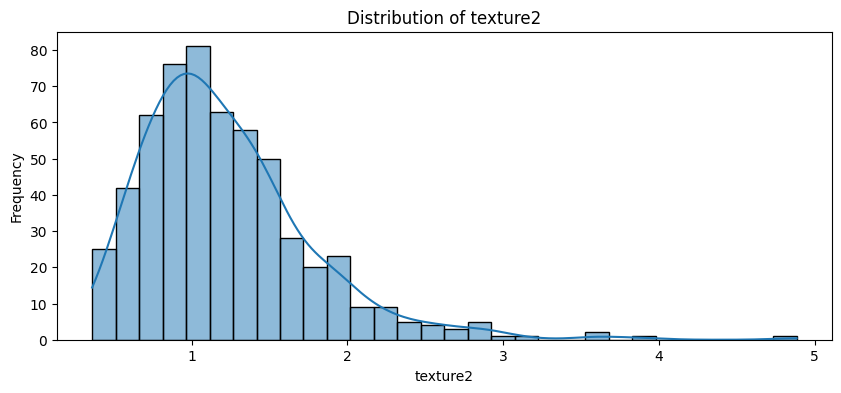

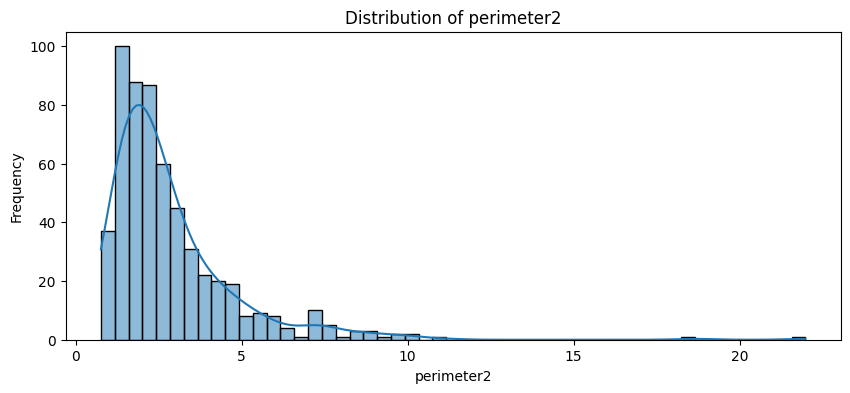

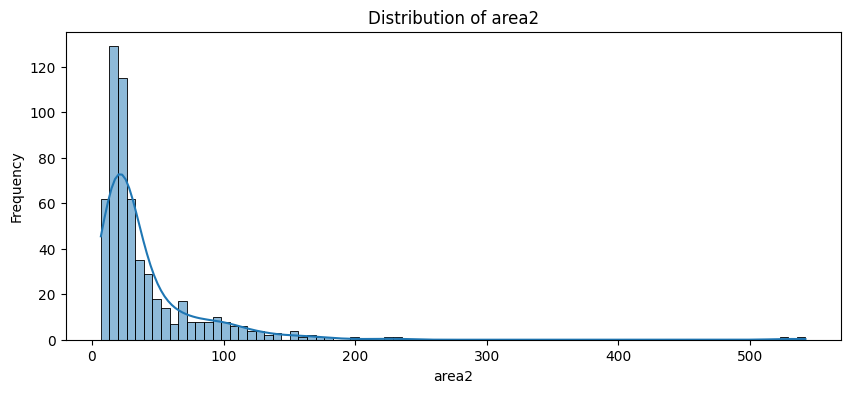

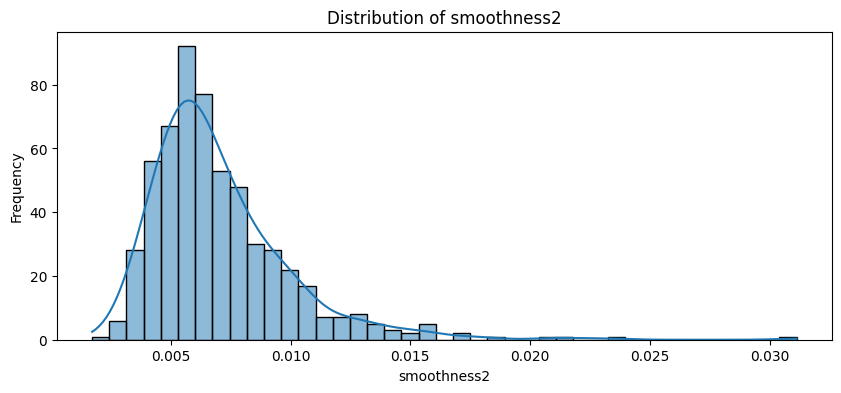

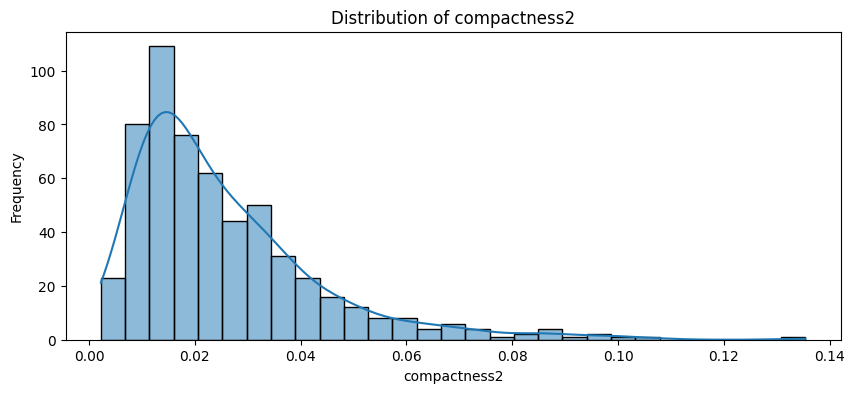

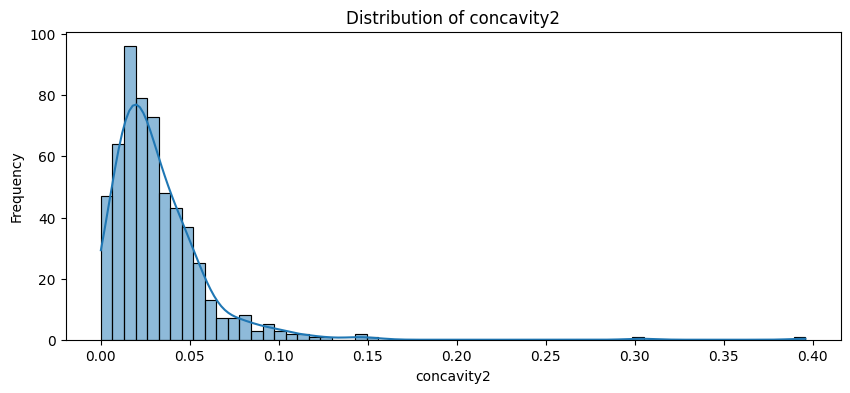

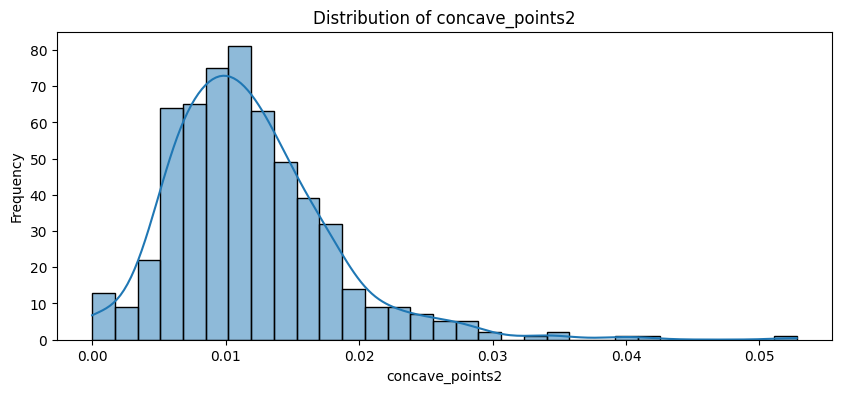

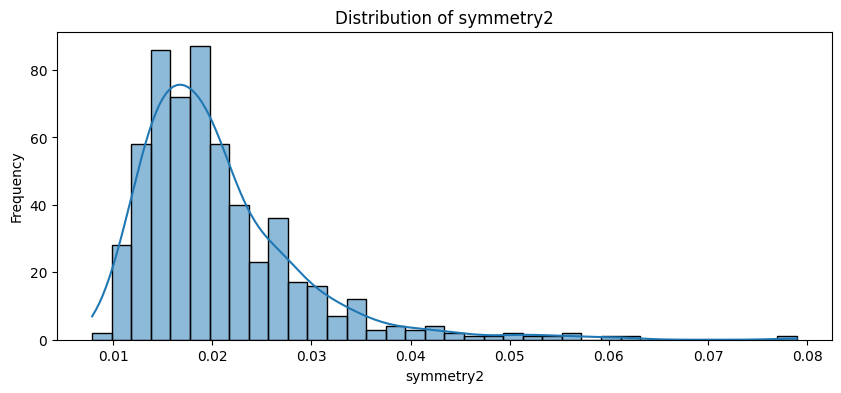

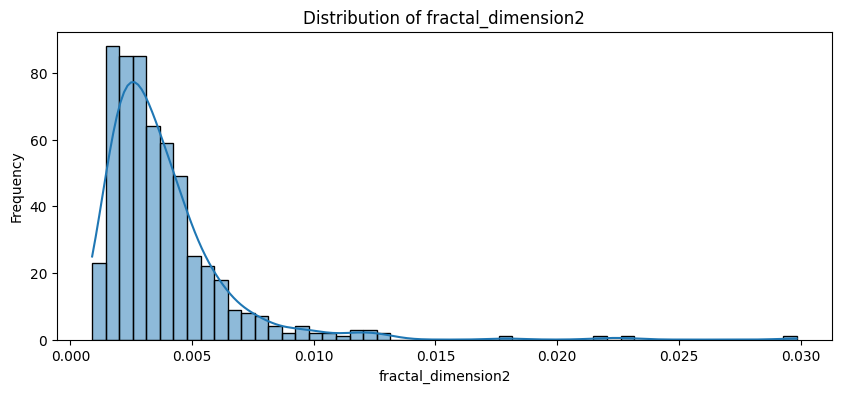

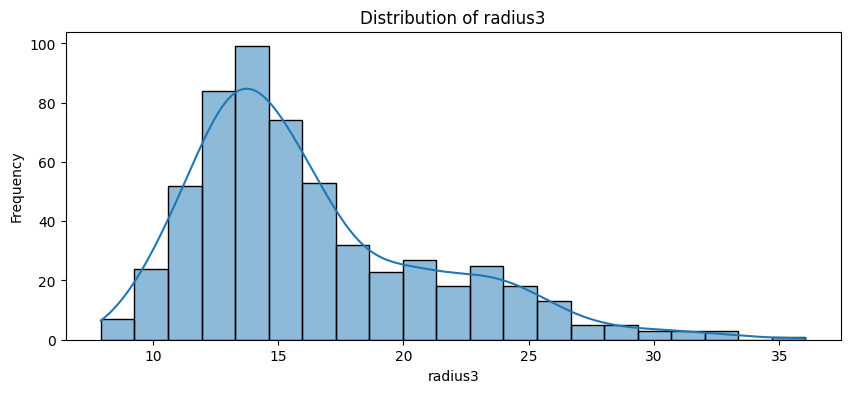

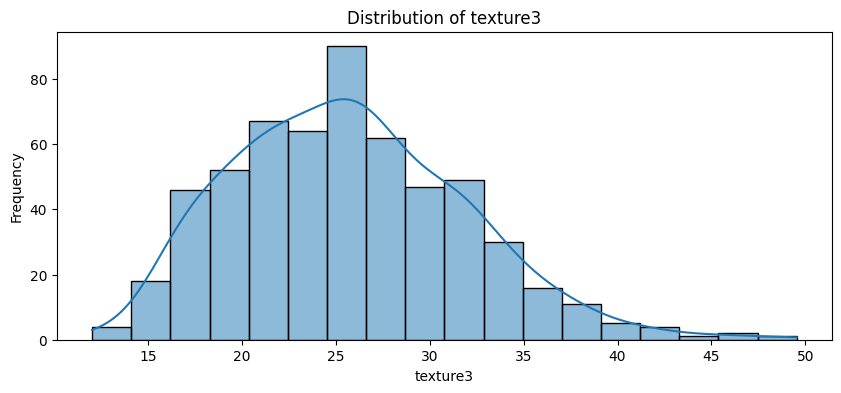

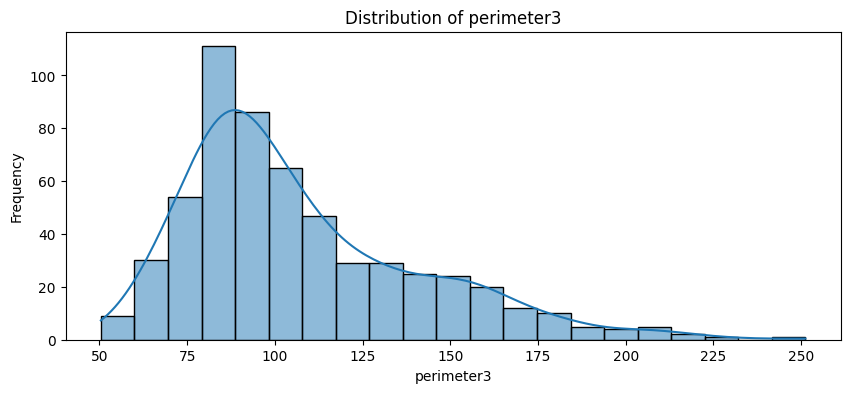

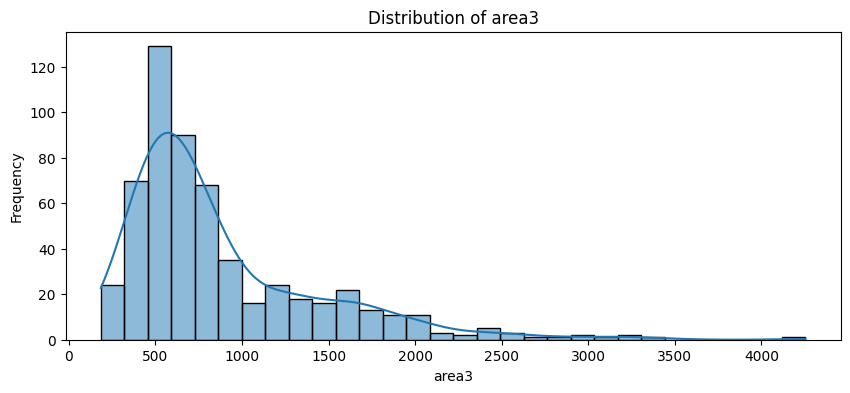

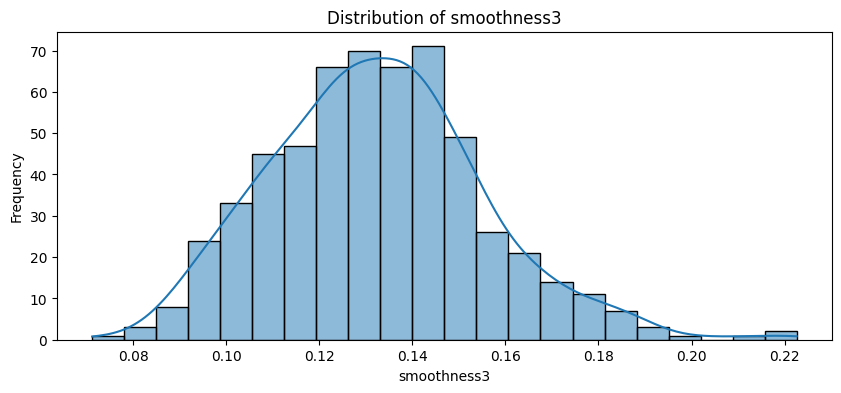

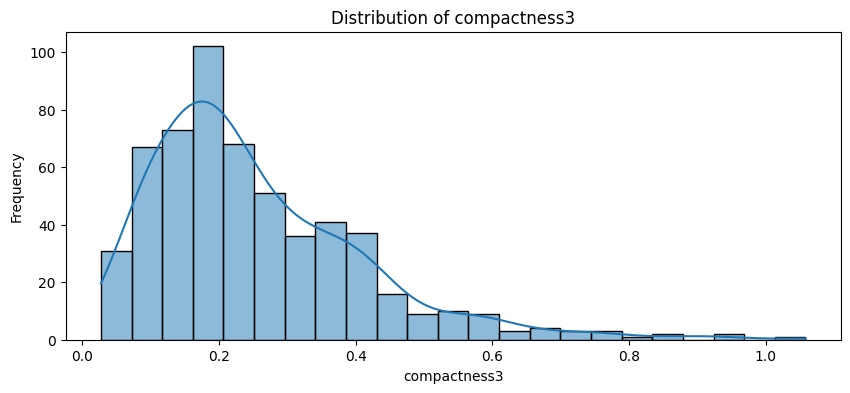

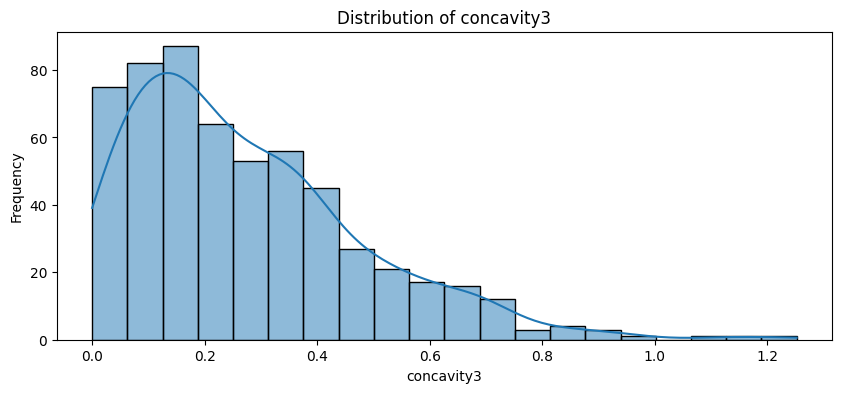

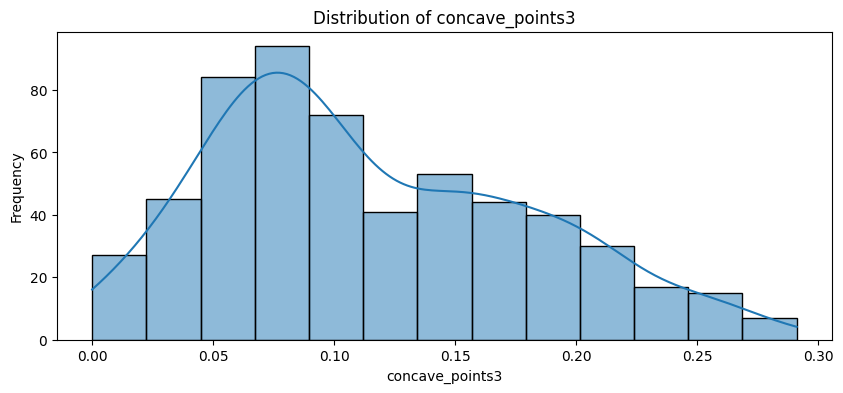

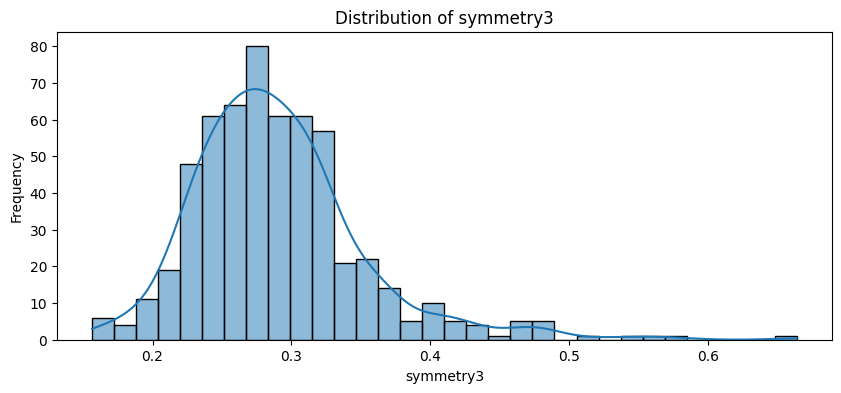

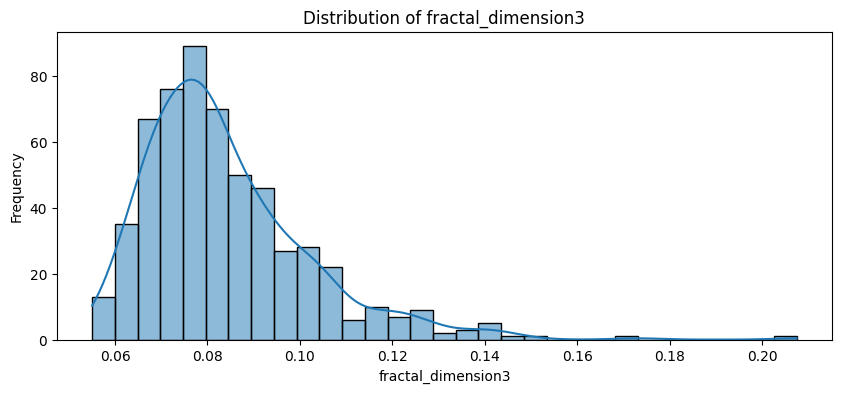

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each column in the DataFrame
for column in x.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 4))
    # Plotting the distribution using seaborn
    sns.histplot(x[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45)

In [135]:
scaling_factors = x_train.max()
custom_scale = 1 / scaling_factors
x_train_scaled = x_train.mul(custom_scale, axis='columns')
x_train_scaled

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
50,0.428884,0.638864,0.399786,0.171092,0.596890,0.143775,0.038824,0.055417,0.491776,0.604269,...,0.360155,0.545377,0.330334,0.121415,0.487421,0.081427,0.044113,0.127971,0.366526,0.316289
313,0.420861,0.317066,0.394489,0.163575,0.594126,0.172814,0.032029,0.044269,0.602961,0.626026,...,0.342397,0.272901,0.323368,0.109967,0.490566,0.153686,0.066486,0.162418,0.510696,0.358265
305,0.423049,0.724342,0.397164,0.166813,0.516517,0.164679,0.046251,0.065258,0.636513,0.603243,...,0.345172,0.670483,0.324005,0.112012,0.428796,0.128639,0.057819,0.165863,0.488701,0.325060
18,0.722465,0.655132,0.695559,0.503798,0.679406,0.297336,0.346532,0.472068,0.520395,0.553674,...,0.758047,0.654792,0.743631,0.563705,0.679245,0.297732,0.429073,0.822597,0.416993,0.366988
8,0.474106,0.645371,0.468165,0.207837,0.879751,0.559351,0.435567,0.464861,0.773026,0.758313,...,0.429800,0.651612,0.422771,0.173789,0.765049,0.510491,0.430511,0.709611,0.659536,0.516627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.530270,0.814552,0.517549,0.263415,0.787146,0.461783,0.384021,0.366004,0.757566,0.726293,...,0.484462,0.787320,0.494029,0.221721,0.753819,0.621645,0.561182,0.589735,0.635432,0.646265
377,0.490883,0.834369,0.459551,0.224750,0.519489,0.136827,0.029780,0.055517,0.467434,0.591441,...,0.407603,0.755513,0.386584,0.159991,0.497754,0.137713,0.063371,0.199139,0.405845,0.340289
163,0.450036,0.657202,0.427234,0.185726,0.699378,0.293862,0.125820,0.140258,0.510197,0.693863,...,0.376804,0.608142,0.347771,0.129995,0.652291,0.220983,0.134824,0.282260,0.341669,0.437687
544,0.505835,0.612245,0.480310,0.233826,0.661921,0.294731,0.086410,0.117744,0.532895,0.686371,...,0.417592,0.524809,0.394785,0.161871,0.567835,0.192533,0.109984,0.235791,0.338807,0.409253


In [136]:
def getResults(x_, y_, starting_point = -1):
    rows = x_.shape[0]
    cols = x_.shape[1]

    z = pd.concat([x_,y_],axis = 1)
    zB = z[z['Diagnosis'] == 'B']
    zM = z[z['Diagnosis'] == 'M']

    B = zB.iloc[:, :-1].to_numpy()
    M = zM.iloc[:, :-1].to_numpy()

    F = np.block([[B, np.ones((B.shape[0], 1))], [-M, -np.ones((M.shape[0], 1))]])
    d = np.ones((z.shape[0],1))
    Q = np.eye(cols+1)
    Q[cols,cols] = 0
    c = np.zeros((cols+1,1))
    return qp_intpoint(Q, c, F, d, 10000, 1e-5, 0.5, starting_point=starting_point)

In [137]:
x_train_scaled_reset = x_train_scaled.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)
xsol, mu, iter = getResults(x_train_scaled_reset, y_train_reset)

20 138.87728621767693
40 81.12107281800371
60 21.791302586886935


In [138]:
iter

65

In [139]:
b_scaled = xsol[-1,-1]
b_scaled

64.74257743224089

In [140]:
w_scaled = xsol[:-1, :]
print(w_scaled)

[[ 43.96553445]
 [  2.02472252]
 [ 30.56035834]
 [ 23.50386897]
 [  0.59499956]
 [ 18.80236649]
 [-31.34420915]
 [-13.929529  ]
 [  0.7476832 ]
 [-26.69050001]
 [ 14.0011666 ]
 [ 19.02107416]
 [ -0.15217412]
 [-37.14758572]
 [-17.84146942]
 [ -9.49619361]
 [ 10.53903655]
 [ -7.45741517]
 [ -8.34381918]
 [ 61.25248986]
 [-81.46427337]
 [-33.63466934]
 [-12.19917571]
 [-82.17350329]
 [ -2.51935755]
 [ 15.71122174]
 [ 11.3534783 ]
 [-17.58726983]
 [ -9.63480081]
 [-25.8172911 ]]


In [141]:
custom_scale_array = custom_scale.values
custom_scale_array = custom_scale_array.reshape((30, 1))
initial_guess_nonscaled = np.block([[w_scaled*custom_scale_array], [b_scaled]])
initial_guess_nonscaled

array([[ 1.60341118e+00],
       [ 5.98853157e-02],
       [ 1.63511816e-01],
       [ 9.39778847e-03],
       [ 4.11195272e+00],
       [ 5.44364982e+01],
       [-7.34400402e+01],
       [-6.92322515e+01],
       [ 2.45948421e+00],
       [-2.73917283e+02],
       [ 5.49712077e+00],
       [ 3.89377158e+00],
       [-8.15947009e-03],
       [-6.85126996e-02],
       [-5.73127832e+02],
       [-7.01343694e+01],
       [ 2.66137287e+01],
       [-1.41265679e+02],
       [-1.05684854e+02],
       [ 2.05269738e+03],
       [-2.26038494e+00],
       [-7.13203336e-01],
       [-4.85635976e-02],
       [-1.93167615e-02],
       [-1.13178686e+01],
       [ 1.48499260e+01],
       [ 9.06827341e+00],
       [-6.05830859e+01],
       [-1.45146140e+01],
       [-1.24420680e+02],
       [ 6.47425774e+01]])

In [142]:
x_train

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
50,11.76,21.60,74.72,427.9,0.08637,0.04966,0.01657,0.011150,0.1495,0.05888,...,12.98,25.72,82.98,516.5,0.10850,0.08615,0.05523,0.03715,0.2433,0.06563
313,11.54,10.72,73.73,409.1,0.08597,0.05969,0.01367,0.008907,0.1833,0.06100,...,12.34,12.87,81.23,467.8,0.10920,0.16260,0.08324,0.04715,0.3390,0.07434
305,11.60,24.49,74.23,417.2,0.07474,0.05688,0.01974,0.013130,0.1935,0.05878,...,12.44,31.62,81.39,476.5,0.09545,0.13610,0.07239,0.04815,0.3244,0.06745
18,19.81,22.15,130.00,1260.0,0.09831,0.10270,0.14790,0.094980,0.1582,0.05395,...,27.32,30.88,186.80,2398.0,0.15120,0.31500,0.53720,0.23880,0.2768,0.07615
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.093530,0.2350,0.07389,...,15.49,30.73,106.20,739.3,0.17030,0.54010,0.53900,0.20600,0.4378,0.10720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,14.54,27.54,96.73,658.8,0.11390,0.15950,0.16390,0.073640,0.2303,0.07077,...,17.46,37.13,124.10,943.2,0.16780,0.65770,0.70260,0.17120,0.4218,0.13410
377,13.46,28.21,85.89,562.1,0.07517,0.04726,0.01271,0.011170,0.1421,0.05763,...,14.69,35.63,97.11,680.6,0.11080,0.14570,0.07934,0.05781,0.2694,0.07061
163,12.34,22.22,79.85,464.5,0.10120,0.10150,0.05370,0.028220,0.1551,0.06761,...,13.58,28.68,87.36,553.0,0.14520,0.23380,0.16880,0.08194,0.2268,0.09082
544,13.87,20.70,89.77,584.8,0.09578,0.10180,0.03688,0.023690,0.1620,0.06688,...,15.05,24.75,99.17,688.6,0.12640,0.20370,0.13770,0.06845,0.2249,0.08492


In [143]:
x_train_reset = x_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)
xsol, mu, iter = getResults(x_train_reset, y_train_reset, initial_guess_nonscaled)

starter given
20 42155.9607489817
40 32560.029576605986
60 8901.651892716573


In [144]:
w = xsol[:-1, :]
b = xsol[-1,:][0]

In [148]:

z_train = pd.concat([x,y],axis = 1)
z_trainB = z_train[z_train['Diagnosis'] == 'B']
z_trainM = z_train[z_train['Diagnosis'] == 'M']

B_train = z_trainB.iloc[:, :-1].to_numpy()
M_train = z_trainM.iloc[:, :-1].to_numpy()
values_M_train = np.dot(M_train, w) + b
values_B_train = np.dot(B_train, w) + b

comply_M_train = np.sum((values_M_train + 1) <= 1e-4)
# Count how many do not comply with the condition for M
not_comply_M_train = np.sum((values_M_train + 1) > 1e-4)

# Count how many comply with values_B being greater than 1 (considering a tolerance)
comply_B_train = np.sum((values_B_train - 1) >= -1e-4)
# Count how many do not comply with the condition for B
not_comply_B_train = np.sum((values_B_train - 1) < -1e-4)

# Printing the results
print(f"Values in M that comply with the restriction: {comply_M_train}")
print(f"Values in M that do not comply with the restriction: {not_comply_M_train}")
print(f"Values in B that comply with the restriction: {comply_B_train}")
print(f"Values in B that do not comply with the restriction: {not_comply_B_train}")

Values in M that comply with the restriction: 210
Values in M that do not comply with the restriction: 2
Values in B that comply with the restriction: 356
Values in B that do not comply with the restriction: 1


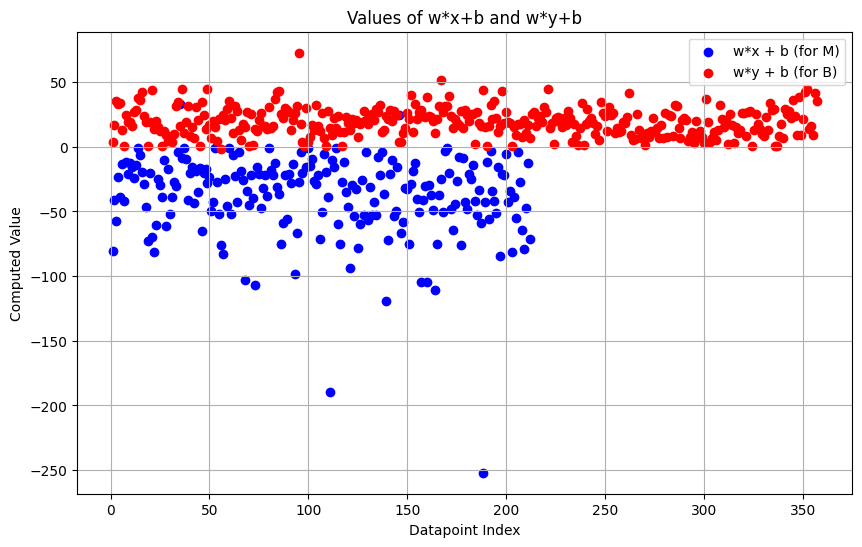

In [149]:
indices_M = np.arange(1, len(values_M_train) + 1)
indices_B = np.arange(1, len(values_B_train) + 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot for matrix M
plt.scatter(indices_M, values_M_train, color='blue', label='w*x + b (for M)')

# Plot for matrix B
plt.scatter(indices_B, values_B_train, color='red', label='w*y + b (for B)')

plt.title('Values of w*x+b and w*y+b')
plt.xlabel('Datapoint Index')
plt.ylabel('Computed Value')
plt.legend()
plt.grid(True)
plt.show()

In [150]:
z_test = pd.concat([x_test,y_test],axis = 1)

# rows = x_test_scaled.shape[0]
# cols = x_train_scaled.shape[1]

x_test_reset = x_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
z_test = pd.concat([x_test_reset, y_test_reset], axis=1)

ztestB = z_test[z_test['Diagnosis'] == 'B']
ztestM = z_test[z_test['Diagnosis'] == 'M']

ztestB

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,10.970,17.20,71.73,371.5,0.08915,0.11130,0.094570,0.03613,0.1489,0.06640,...,26.87,90.14,476.4,0.13910,0.40820,0.47790,0.15550,0.2540,0.09532,B
3,11.900,14.65,78.11,432.8,0.11520,0.12960,0.037100,0.03003,0.1995,0.07839,...,16.51,86.26,509.6,0.14240,0.25170,0.09420,0.06042,0.2727,0.10360,B
4,9.268,12.87,61.49,248.7,0.16340,0.22390,0.097300,0.05252,0.2378,0.09502,...,16.38,69.05,300.2,0.19020,0.34410,0.20990,0.10250,0.3038,0.12520,B
5,11.060,14.96,71.49,373.9,0.10330,0.09097,0.053970,0.03341,0.1776,0.06907,...,19.90,79.76,440.0,0.14180,0.22100,0.22990,0.10750,0.3301,0.09080,B
6,12.000,28.23,76.77,442.5,0.08437,0.06450,0.040550,0.01945,0.1615,0.06104,...,37.88,85.07,523.7,0.12080,0.18560,0.18110,0.07116,0.2447,0.08194,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,12.720,17.67,80.98,501.3,0.07896,0.04522,0.014020,0.01835,0.1459,0.05544,...,20.96,88.87,586.8,0.10680,0.09605,0.03469,0.03612,0.2165,0.06025,B
108,12.070,13.44,77.83,445.2,0.11000,0.09009,0.037810,0.02798,0.1657,0.06608,...,15.77,86.92,549.9,0.15210,0.16320,0.16220,0.07393,0.2781,0.08052,B
109,11.890,21.17,76.39,433.8,0.09773,0.08120,0.025550,0.02179,0.2019,0.06290,...,27.21,85.09,522.9,0.14260,0.21870,0.11640,0.08263,0.3075,0.07351,B
110,13.200,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.01105,0.1487,0.05635,...,27.82,88.28,602.0,0.11010,0.15080,0.22980,0.04970,0.2767,0.07198,B


In [151]:
B_test = ztestB.iloc[:, :-1].to_numpy()
M_test = ztestM.iloc[:, :-1].to_numpy()

In [152]:
values_test_M = np.dot(M_test, w_scaled) + b_scaled
values_test_B = np.dot(B_test, w_scaled) + b_scaled

comply_M = np.sum((values_test_M + 1) <= 1e-4)
# Count how many do not comply with the condition for M
not_comply_M = np.sum((values_test_M + 1) > 1e-4)

# Count how many comply with values_B being greater than 1 (considering a tolerance)
comply_B = np.sum((values_test_B - 1) >= -1e-4)
# Count how many do not comply with the condition for B
not_comply_B = np.sum((values_test_B - 1) < -1e-4)

# Printing the results
print(f"Values in M that comply with the restriction: {comply_M}")
print(f"Values in M that do not comply with the restriction: {not_comply_M}")
print(f"Values in B that comply with the restriction: {comply_B}")
print(f"Values in B that do not comply with the restriction: {not_comply_B}")

Values in M that comply with the restriction: 42
Values in M that do not comply with the restriction: 0
Values in B that comply with the restriction: 0
Values in B that do not comply with the restriction: 72


In [153]:
TP = comply_M  # M values that are correctly less than -1
FN = not_comply_M  # M values that are incorrectly not less than -1
TN = comply_B  # B values that are correctly greater than 1
FP = not_comply_B  # B values that are incorrectly not greater than 1

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate precision
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Calculate recall
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Calculate F1 score
F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Printing the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {F1:.4f}")

Accuracy: 0.3684
Precision: 0.3684
Recall: 1.0000
F1 Score: 0.5385
